# Se importan las librerías necesarias

In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import ast
import requests
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Se cargan los datset solicitados

In [31]:
movie = pd.read_csv("datasets/movies_dataset.csv")
credits = pd.read_csv("datasets/credits.csv")

C:\Users\Sergio\AppData\Local\Temp\ipykernel_54168\2045859923.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie = pd.read_csv("datasets/movies_dataset.csv")


# Visualizacion de los dataset

In [32]:
movie

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [33]:
credits

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [34]:
movie.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [35]:
credits.dtypes

cast    object
crew    object
id       int64
dtype: object

# Desanidado de las columnas que contienen diccionarios o listas
En este caso en dicha columnas lo que hago es buscar los datos que voy a necesitar y los sobreescribo en la columna

In [36]:
# Funcion para extraer el nombre de la coleccion de las peliculas con franquicia
def coleccion(dato):
    if pd.notnull(dato):
        try:
            datos = eval(dato)
            nombre = datos['name']
            return (nombre)
        except (SyntaxError, KeyError, TypeError):
            pass  
    return dato
# Funcion para extrar los datos que necesito de las columnas genres, production_companies y production_countries
def extraer(datos):
    try:
        listaDatos = ast.literal_eval(datos)
        if isinstance(listaDatos, list):
            return [dato['name'] for dato in listaDatos]
    except (SyntaxError, ValueError):
        pass
    return []
    
movie['belongs_to_collection'] = movie['belongs_to_collection'].apply(coleccion)

columnas = ['genres','production_companies', 'production_countries']
for columna in columnas:
    movie[columna] = movie[columna].fillna('[]')
    movie[columna] = movie[columna].apply(extraer)

In [37]:
# De cast solo me interesan los nombres de los actores
def actor(casts):
    try:
        cast_list = eval(casts)  
        nombre = [cast['name'] for cast in cast_list]
        return nombre
    except (SyntaxError, ValueError):
        return []

credits['cast'] = credits['cast'].apply(actor)

In [38]:
# De crew solo me interesa el nombre del director
def director(crew):
    try:
        crew_list = eval(crew) 
        for member in crew_list:
            if member['job'] == 'Director':
                return member['name']
        return None  
    except (SyntaxError, ValueError):
        return None

credits['crew'] = credits['crew'].apply(director)

# Mostrar los DataFrames con los datos actualizados

In [39]:
movie.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,Toy Story Collection,30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,Grumpy Old Men Collection,0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,Father of the Bride Collection,0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [40]:

credits.head()

,cast,crew,id
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,15602
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,31357
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,11862


In [41]:
# Rellenar los valores nulos de las columnas "revenue" y "budget" con el número 0
movie["revenue"].fillna(0, inplace=True)
movie["budget"].fillna(0, inplace=True)

In [42]:
# Convertir las columnas "budget" y "revenue" a valores numéricos
movie["budget"] = pd.to_numeric(movie["budget"], errors="coerce")
movie["revenue"] = pd.to_numeric(movie["revenue"], errors="coerce")

In [43]:
# Calcular el retorno de inversión y crear la columna 'return'
movie['return'] = movie['revenue'] / movie['budget']
movie['return'].fillna(0, inplace=True)  # Rellenar los valores NaN con 0
movie.replace([np.inf, -np.inf], 0, inplace=True)

In [44]:
# Eliminar los valores nulos en la columna "release_date"
movie.dropna(subset=["release_date"], inplace=True)

In [45]:
# Las fechas, deberán tener el formato AAAA-mm-dd, además se crea la columna release_year donde extraerán el año de la fecha de estreno.
movie["release_date"] = pd.to_datetime(movie["release_date"], errors="coerce").dt.strftime('%Y-%m-%d')
movie["release_year"] = pd.to_datetime(movie["release_date"], errors="coerce").dt.year
movie["release_year"] = movie["release_year"].astype(float).astype(pd.Int32Dtype())


In [46]:
# Columnas a eliminar
columnas_a_eliminar = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage','spoken_languages']
movie.drop(columns=columnas_a_eliminar, inplace=True)

In [47]:
# Se crea el Dataset peliculas con la combinacion de movie y credits por el id
movie['id'] = movie['id'].astype(str)
credits['id'] = credits['id'].astype(str)
peliculas = pd.merge(movie, credits, on='id', how='inner')


In [48]:
# Visualizacion del dataset peliculas
peliculas.head()

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,status,tagline,title,vote_average,vote_count,return,release_year,cast,crew
0,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,...,81.0,Released,NaN,Toy Story,7.7,5415.0,12.451801,1995,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,...,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,4.043035,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,Grumpy Old Men Collection,0.0,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,...,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,0.000000,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,NaN,16000000.0,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,...,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,5.090760,1995,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,Father of the Bride Collection,0.0,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,...,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,0.000000,1995,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


In [49]:
peliculas.dtypes

belongs_to_collection     object
budget                   float64
genres                    object
id                        object
original_language         object
overview                  object
popularity                object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
status                    object
tagline                   object
title                     object
vote_average             float64
vote_count               float64
return                   float64
release_year               Int32
cast                      object
crew                      object
dtype: object

In [50]:
# renombro algunas columnas para mejor comprencion y tambien cambio los tipos de variables en la que hace falta
peliculas.rename(columns={'belongs_to_collection': 'franquicia', 'production_companies': 'productora', 'production_countries': 'pais','original_language': 'idioma', 'spoken_languages': 'lenguajes_adicionales', 'tagline': 'eslogan', 'crew': 'director'}, inplace=True)

peliculas["id"] = peliculas["id"].astype(int)
peliculas["popularity"] = peliculas["popularity"].astype(float)
peliculas["vote_count"] = peliculas["vote_count"].astype(int)

# Limpieza adicional de datos

In [51]:
#cantidad de filas duplicadas 
peliculas.duplicated(subset='id').sum()

106

In [52]:
#se revisan las filas con id duplicado
peliculas[peliculas.id.duplicated(keep=False)].sort_values(by="id") 

,franquicia,budget,genres,id,idioma,overview,popularity,productora,pais,release_date,...,runtime,status,eslogan,title,vote_average,vote_count,return,release_year,cast,director
25929,NaN,0.0,"[Drama, Horror, Science Fiction, Mystery]",3057,en,Frankenstein is a 2004 U.S. television miniser...,1.215853,"[Hallmark Entertainment, RTL2]","[Germany, Slovakia, United States of America]",2004-10-05,...,115.0,Released,NaN,Frankenstein,6.0,14,0.00000,2004,"[Luke Goss, Alec Newman, Julie Delpy, William ...",Kevin Connor
25930,NaN,0.0,"[Drama, Horror, Science Fiction, Mystery]",3057,en,Frankenstein is a 2004 U.S. television miniser...,1.215853,"[Hallmark Entertainment, RTL2]","[Germany, Slovakia, United States of America]",2004-10-05,...,115.0,Released,NaN,Frankenstein,6.0,14,0.00000,2004,"[Luke Goss, Alec Newman, Julie Delpy, William ...",Kevin Connor
5887,NaN,30000000.0,"[Comedy, Crime, Drama, Romance, Thriller]",4912,en,"Television made him famous, but his biggest hi...",11.331072,"[Miramax Films, Allied Filmmakers, Mad Chance]",[United States of America],2002-12-30,...,113.0,Released,Some things are better left top secret.,Confessions of a Dangerous Mind,6.6,281,1.10046,2002,"[Sam Rockwell, Drew Barrymore, Julia Roberts, ...",George Clooney
5888,NaN,30000000.0,"[Comedy, Crime, Drama, Romance, Thriller]",4912,en,"Television made him famous, but his biggest hi...",11.331072,"[Miramax Films, Allied Filmmakers, Mad Chance]",[United States of America],2002-12-30,...,113.0,Released,Some things are better left top secret.,Confessions of a Dangerous Mind,6.6,281,1.10046,2002,"[Sam Rockwell, Drew Barrymore, Julia Roberts, ...",George Clooney
5889,NaN,30000000.0,"[Comedy, Crime, Drama, Romance, Thriller]",4912,en,"Television made him famous, but his biggest hi...",7.645827,"[Miramax Films, Allied Filmmakers, Mad Chance]",[United States of America],2002-12-30,...,113.0,Released,Some things are better left top secret.,Confessions of a Dangerous Mind,6.6,281,1.10046,2002,"[Sam Rockwell, Drew Barrymore, Julia Roberts, ...",George Clooney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24206,NaN,0.0,"[Comedy, Drama]",265189,sv,"While holidaying in the French Alps, a Swedish...",12.165685,"[Motlys, Coproduction Office, Film i Väst]","[Norway, Sweden, France]",2014-08-15,...,118.0,Released,NaN,Force Majeure,6.8,255,0.00000,2014,"[Lisa Loven Kongsli, Johannes Bah Kuhnke, Clar...",Ruben Östlund
33226,NaN,980000.0,"[Drama, Fantasy]",298721,th,"In a hospital, ten soldiers are being treated ...",2.535419,"[Match Factory, The, Louverture Films, Tordenf...","[United Kingdom, United States of America, Fra...",2015-09-02,...,122.0,Released,NaN,Cemetery of Splendour,4.4,50,0.00000,2015,"[Jenjira Pongpas, Banlop Lomnoi, Jarinpattra R...",Apichatpong Weerasethakul
33227,NaN,980000.0,"[Drama, Fantasy]",298721,th,"In a hospital, ten soldiers are being treated ...",2.535419,"[Match Factory, The, Louverture Films, Tordenf...","[United Kingdom, United States of America, Fra...",2015-09-02,...,122.0,Released,NaN,Cemetery of Splendour,4.4,50,0.00000,2015,"[Jenjira Pongpas, Banlop Lomnoi, Jarinpattra R...",Apichatpong Weerasethakul
33228,NaN,980000.0,"[Drama, Fantasy]",298721,th,"In a hospital, ten soldiers are being treated ...",2.535419,"[Match Factory, The, Louverture Films, Tordenf...","[United Kingdom, United States of America, Fra...",2015-09-02,...,122.0,Released,NaN,Cemetery of Splendour,4.4,50,0.00000,2015,"[Jenjira Pongpas, Banlop Lomnoi, Jarinpattra R...",Apichatpong Weerasethakul


In [53]:
#se eliminan las filas con id duplicado conservando las últimas cargadas en la base
peliculas.drop_duplicates(subset="id", keep="last", inplace=True) 

In [54]:
peliculas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45345 entries, 0 to 45450
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   franquicia    4485 non-null   object 
 1   budget        45345 non-null  float64
 2   genres        45345 non-null  object 
 3   id            45345 non-null  int32  
 4   idioma        45334 non-null  object 
 5   overview      44404 non-null  object 
 6   popularity    45345 non-null  float64
 7   productora    45345 non-null  object 
 8   pais          45345 non-null  object 
 9   release_date  45345 non-null  object 
 10  revenue       45345 non-null  float64
 11  runtime       45099 non-null  float64
 12  status        45265 non-null  object 
 13  eslogan       20387 non-null  object 
 14  title         45345 non-null  object 
 15  vote_average  45345 non-null  float64
 16  vote_count    45345 non-null  int32  
 17  return        45345 non-null  float64
 18  release_year  45345 non-nu

In [55]:
#se revisa la cantidad de valores faltantes para cada feature
peliculas.isna().sum() 

franquicia      40860
budget              0
genres              0
id                  0
idioma             11
overview          941
popularity          0
productora          0
pais                0
release_date        0
revenue             0
runtime           246
status             80
eslogan         24958
title               0
vote_average        0
vote_count          0
return              0
release_year        0
cast                0
director          835
dtype: int64

In [56]:
peliculas.dtypes

franquicia       object
budget          float64
genres           object
id                int32
idioma           object
overview         object
popularity      float64
productora       object
pais             object
release_date     object
revenue         float64
runtime         float64
status           object
eslogan          object
title            object
vote_average    float64
vote_count        int32
return          float64
release_year      Int32
cast             object
director         object
dtype: object

# Sistema de recomendacion de peliculas
Utilize el model de matriz de coseno para hacer las predicciones

In [28]:
peliculasV2 = peliculas.copy()

peliculasV2.reset_index(drop=True, inplace=True)

peliculasV2['franquicia'] = peliculasV2['franquicia'].fillna('')

peliculasV2['text_data'] = peliculasV2['genres'].apply(lambda x: ' '.join(x)) + ' ' + peliculasV2['title'] + ' ' + peliculasV2['productora'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(peliculasV2['text_data'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

peliculasV2['recomendacion'] = [[] for _ in range(len(peliculasV2))]

def obtener_similares(idx, num_similares=5):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_similares+1]
    movie_indices = [i[0] for i in sim_scores]
    return peliculasV2['title'].iloc[movie_indices].tolist()

for idx in tqdm(peliculasV2.index, desc="Procesando recomendaciones"):
    peliculasV2.at[idx, 'recomendacion'] = obtener_similares(idx)

peliculasV2.to_csv('datasets/peliculas.csv', index=False)


Procesando recomendaciones: 100%|██████████| 45345/45345 [16:00<00:00, 47.23it/s]


In [29]:
peliculasV2

,franquicia,budget,genres,id,idioma,overview,popularity,productora,pais,release_date,...,eslogan,title,vote_average,vote_count,return,release_year,cast,director,text_data,recomendacion
0,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,...,NaN,Toy Story,7.7,5415,12.451801,1995,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,Animation Comedy Family Toy Story Pixar Animat...,"[Toy Story 2, Toy Story 3, Toy Story of Terror..."
1,,65000000.0,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,...,Roll the dice and unleash the excitement!,Jumanji,6.9,2413,4.043035,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,Adventure Fantasy Family Jumanji TriStar Pictu...,"[Blind Fury, Kazaam, Three Men and a Baby, Thr..."
2,Grumpy Old Men Collection,0.0,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.712900,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92,0.000000,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,Romance Comedy Grumpier Old Men Warner Bros. L...,"[Grumpy Old Men, G-Men, Without Men, A Gatheri..."
3,,16000000.0,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,...,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34,5.090760,1995,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,Comedy Drama Romance Waiting to Exhale Twentie...,"[Take Her, She's Mine, Can-Can, This Above All..."
4,Father of the Bride Collection,0.0,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173,0.000000,1995,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,Comedy Father of the Bride Part II Sandollar P...,"[Father of the Bride, True Identity, Father of..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45340,,0.0,"[Drama, Action, Romance]",30840,en,"Yet another version of the classic epic, with ...",5.683753,"[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State...",1991-05-13,...,NaN,Robin Hood,5.7,26,0.000000,1991,"[Patrick Bergin, Uma Thurman, David Morrissey,...",John Irvin,Drama Action Romance Robin Hood Westdeutscher ...,"[The Adventures of Robin Hood, Home Alone 4, R..."
45341,,0.0,[Drama],111109,tl,An artist struggles to finish his work while a...,0.178241,[Sine Olivia],[Philippines],2011-11-17,...,NaN,Century of Birthing,9.0,3,0.000000,2011,"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe...",Lav Diaz,Drama Century of Birthing Sine Olivia,"[My Twentieth Century, Century, Century of the..."
45342,,0.0,"[Action, Drama, Thriller]",67758,en,"When one of her hits goes wrong, a professiona...",0.903007,[American World Pictures],[United States of America],2003-08-01,...,A deadly game of wits.,Betrayal,3.8,6,0.000000,2003,"[Erika Eleniak, Adam Baldwin, Julie du Page, J...",Mark L. Lester,Action Drama Thriller Betrayal American World ...,"[Betrayal, The Betrayal (Nerakhoon), Groupie, ..."
45343,,0.0,[],227506,en,"In a small town live two brothers, one a minis...",0.003503,[Yermoliev],[Russia],1917-10-21,...,NaN,Satan Triumphant,0.0,0,0.000000,1917,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",Yakov Protazanov,Satan Triumphant Yermoliev,"[AWOL-72, Asylum of Satan, Daughters of Satan,..."


# Análisis exploratorio de los datos:

In [57]:
# Estadísticas descriptivas para columnas numéricas
peliculas.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,return,release_year
count,4.534500e+04,45345.000000,45345.000000,4.534500e+04,45099.000000,45345.000000,45345.000000,4.534500e+04,45345.000000
mean,4.232673e+06,108035.740479,2.926052,1.123390e+07,94.179893,5.624320,110.137766,6.604937e+02,1991.882280
std,1.744391e+07,112180.079341,6.010770,6.441058e+07,38.346636,1.915178,491.904429,7.471882e+04,24.053016
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1874.000000
25%,0.000000e+00,26390.000000,0.388844,0.000000e+00,85.000000,5.000000,3.000000,0.000000e+00,1978.000000
50%,0.000000e+00,59852.000000,1.130300,0.000000e+00,95.000000,6.000000,10.000000,0.000000e+00,2001.000000
75%,0.000000e+00,156597.000000,3.689610,0.000000e+00,107.000000,6.800000,34.000000,0.000000e+00,2010.000000
max,3.800000e+08,469172.000000,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,1.239638e+07,2020.000000


budget: La mayoría de las películas tienen un presupuesto de 0, lo que sugiere que para muchas películas el presupuesto puede no estar disponible o no se ha introducido en la base de datos. La película con el mayor presupuesto tiene un presupuesto de 380 millones de dólares.

id: El campo de identificación varía de 2 a 469172, pero la media está alrededor de 108036.

popularity: La popularidad varía considerablemente, desde 0 hasta aproximadamente 547.49, con una media de 2.93.

revenue: Al igual que el presupuesto, la mayoría de las películas tienen unos ingresos de 0, lo que indica que puede que no se disponga de información sobre los ingresos para muchas películas. La película con los ingresos más altos ha recaudado aproximadamente 2.788 mil millones de dólares.

vote_average: La puntuación media de las votaciones es de 5.62 en una escala de 0 a 10, y la mediana es 6. Esto sugiere que la mayoría de las películas reciben calificaciones bastante positivas.

vote_count: El número de votos recibidos por las películas varía enormemente, desde 0 hasta 14075. Sin embargo, la media de votos es de 110, y la mediana es de 10, lo que indica que la mayoría de las películas reciben un número relativamente pequeño de votos.

return: Los retornos varían desde 0 hasta alrededor de 12.396 millones, con una media de 660. Pero dada la desviación estándar y el percentil 75 igual a 0, podemos deducir que muchos valores son 0 o cercanos a 0.

release_year: Las películas de la base de datos fueron lanzadas entre 1874 y 2020, con una media en 1991. Más del 75% de las películas fueron lanzadas después de 1978.

Por favor, ten en cuenta que estas interpretaciones dependen de la exactitud y completitud de los datos. En particular, los muchos valores de 0 en budget, revenue y return podrían indicar que falta mucha información en estos campos.

C:\Users\Sergio\AppData\Local\Temp\ipykernel_54168\2453560918.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  idiomas_frecuentes = top_idiomas.append(otros_idiomas)


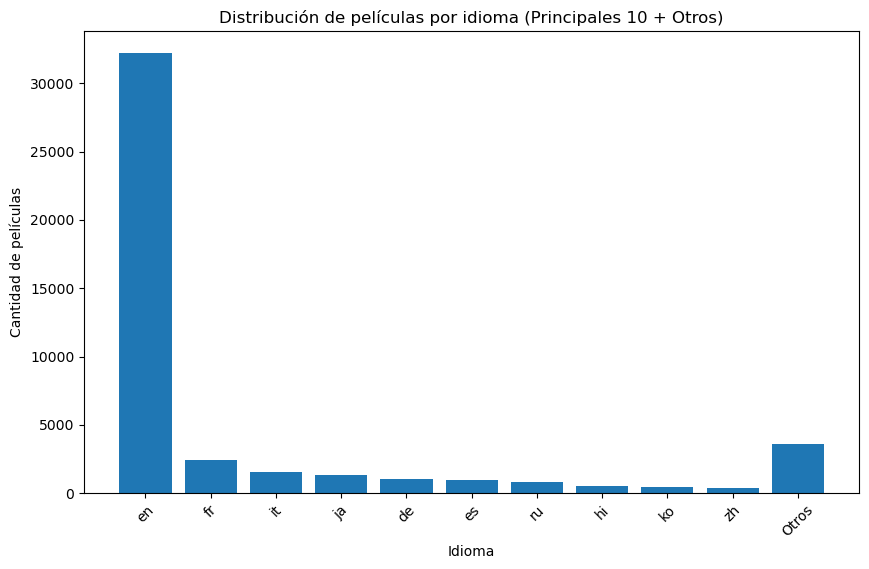

In [59]:
# Distribución de películas por idioma con agrupación de idiomas menos frecuentes en "Otros"

idioma_counts = peliculas['idioma'].value_counts()
num_top_idiomas = 10
top_idiomas = idioma_counts[:num_top_idiomas]
otros_idiomas = pd.Series(idioma_counts[num_top_idiomas:].sum(), index=['Otros'])
idiomas_frecuentes = top_idiomas.append(otros_idiomas)
plt.figure(figsize=(10, 6))
plt.bar(idiomas_frecuentes.index, idiomas_frecuentes.values)
plt.xlabel('Idioma')
plt.ylabel('Cantidad de películas')
plt.title(f'Distribución de películas por idioma (Principales {num_top_idiomas} + Otros)')
plt.xticks(rotation=45)
plt.show()


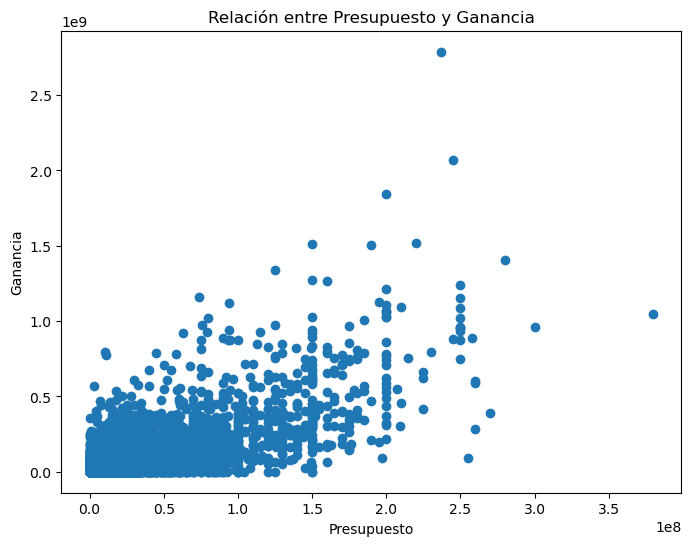

In [60]:
# Relación entre presupuesto y ganancia
plt.figure(figsize=(8, 6))
plt.scatter(peliculas['budget'], peliculas['revenue'])
plt.xlabel('Presupuesto')
plt.ylabel('Ganancia')
plt.title('Relación entre Presupuesto y Ganancia')
plt.show()


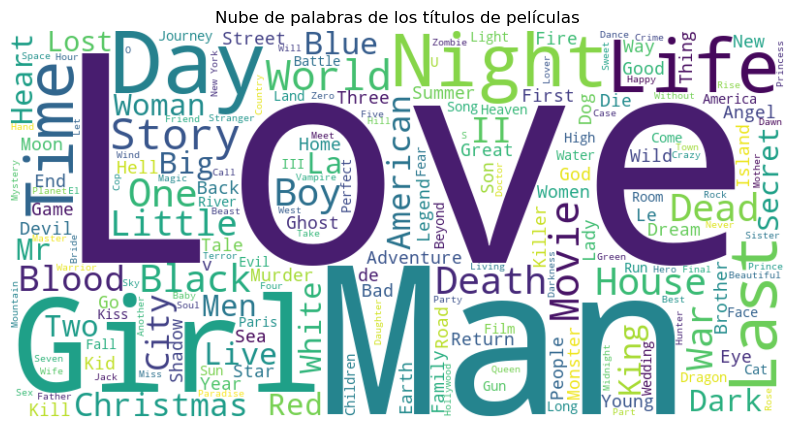

In [61]:
# Palabras mas frecuentes en el titulo
from wordcloud import WordCloud

all_titles = ' '.join(peliculas['title'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de los títulos de películas')
plt.show()


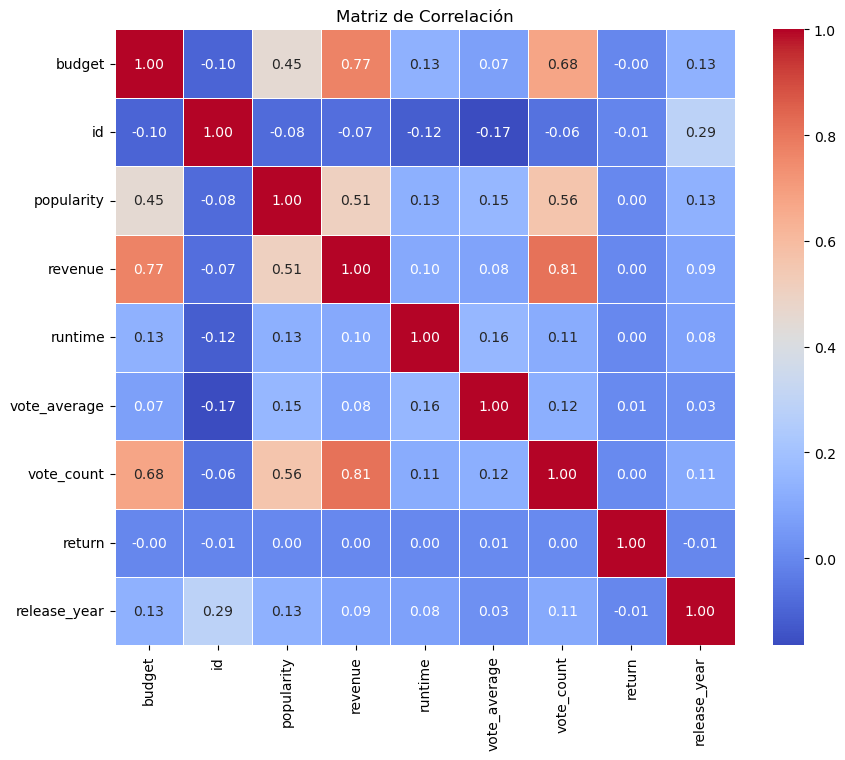

In [62]:
# Matriz de correlacion
peliculas['franquicia'].fillna('', inplace=True)
peliculas['genres'].fillna('', inplace=True)
peliculas['idioma'].fillna('', inplace=True)
peliculas['eslogan'].fillna('', inplace=True)

matriz_correlacion = peliculas.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()
